# Import packages

In [5]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib as mpl

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


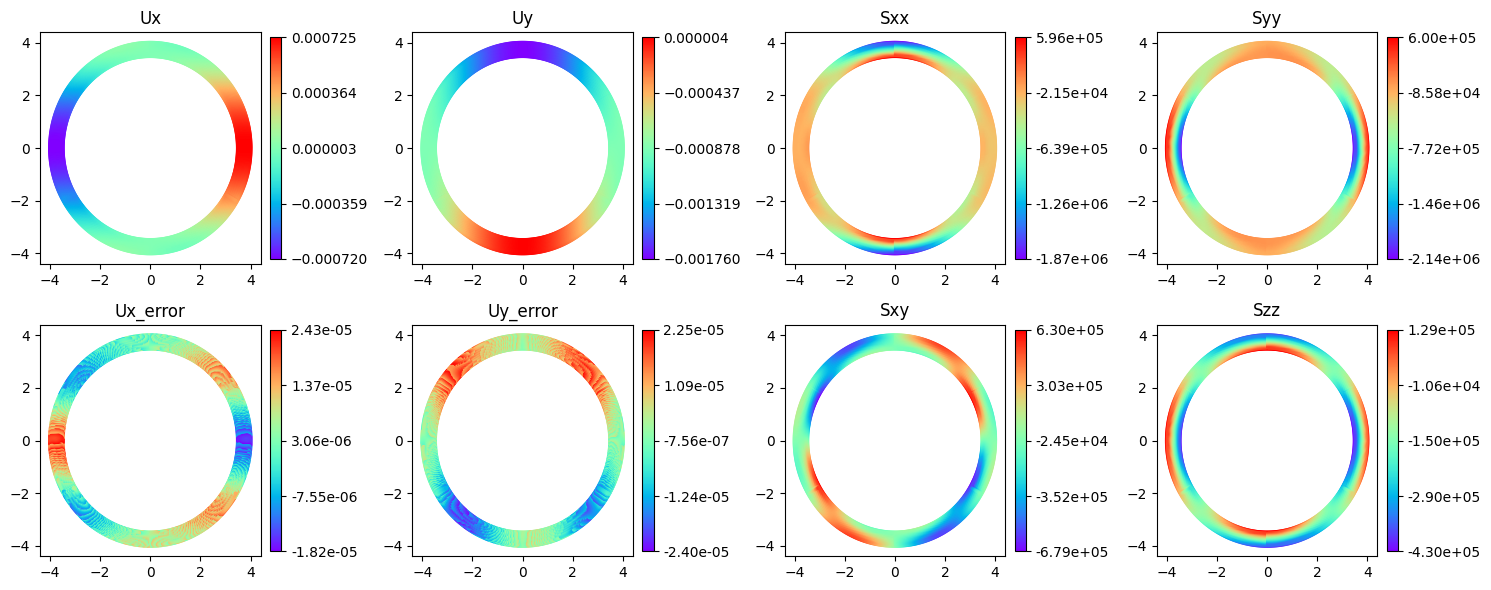

In [6]:
# Compare with the results from Abaqus
FEM_U2f = np.genfromtxt('/content/drive/MyDrive/2Dring/FEM_displacement_2f.txt', dtype = float)
# noisy obesrvational data
KRG_U2f = np.genfromtxt('/content/drive/MyDrive/2Dring/kriging_2f_field.txt', dtype = float)
# PINN results
field_2f = np.genfromtxt('/content/drive/MyDrive/2Dring/results/2Dring_2f_field.txt', dtype = float)

ste=5

fig, axs = plt.subplots(2, 4, figsize=(15,6), dpi=100)
plt.setp(axs, xticks=[-4,-2,0,2,4], yticks=[-4,-2,0,2,4])
p=axs[0, 0].scatter(x=field_2f[:,0], y=field_2f[:,1], s=4, c=field_2f[:,2], cmap='rainbow')
axs[0, 0].set_title("Ux")
fig.colorbar(p, ax=axs[0, 0], fraction=0.046, pad=0.04, ticks=np.linspace(field_2f[:,2].min(),field_2f[:,2].max(),ste))
p=axs[0, 1].scatter(x=field_2f[:,0], y=field_2f[:,1], s=4, c=field_2f[:,3], cmap='rainbow')
axs[0, 1].set_title("Uy")
fig.colorbar(p, ax=axs[0, 1], fraction=0.046, pad=0.04, ticks=np.linspace(field_2f[:,3].min(),field_2f[:,3].max(),ste))
p=axs[1, 0].scatter(x=field_2f[:,0], y=field_2f[:,1], s=4, c=field_2f[:,2]-FEM_U2f[:,1], cmap='rainbow')
axs[1, 0].set_title("Ux_error")
fig.colorbar(p, ax=axs[1, 0], fraction=0.046, pad=0.04, format='%.2e', ticks=np.linspace((field_2f[:,2]-FEM_U2f[:,1]).min(),(field_2f[:,2]-FEM_U2f[:,1]).max(),ste))
p=axs[1, 1].scatter(x=field_2f[:,0], y=field_2f[:,1], s=4, c=field_2f[:,3]-FEM_U2f[:,2], cmap='rainbow')
axs[1, 1].set_title("Uy_error")
fig.colorbar(p, ax=axs[1, 1], fraction=0.046, pad=0.04, format='%.2e', ticks=np.linspace((field_2f[:,3]-FEM_U2f[:,2]).min(),(field_2f[:,3]-FEM_U2f[:,2]).max(),ste))
p=axs[0, 2].scatter(x=field_2f[:,0], y=field_2f[:,1], s=4, c=field_2f[:,4], cmap='rainbow')
axs[0, 2].set_title("Sxx")
fig.colorbar(p, ax=axs[0, 2], fraction=0.046, pad=0.04, format='%.2e', ticks=np.linspace(field_2f[:,4].min(),field_2f[:,4].max(),ste))
p=axs[0, 3].scatter(x=field_2f[:,0], y=field_2f[:,1], s=4, c=field_2f[:,5], cmap='rainbow')
axs[0, 3].set_title("Syy")
fig.colorbar(p, ax=axs[0, 3], fraction=0.046, pad=0.04, format='%.2e', ticks=np.linspace(field_2f[:,5].min(),field_2f[:,5].max(),ste))
p=axs[1, 2].scatter(x=field_2f[:,0], y=field_2f[:,1], s=4, c=field_2f[:,6], cmap='rainbow')
axs[1, 2].set_title("Sxy")
fig.colorbar(p, ax=axs[1, 2], fraction=0.046, pad=0.04, format='%.2e', ticks=np.linspace(field_2f[:,6].min(),field_2f[:,6].max(),ste))
p=axs[1, 3].scatter(x=field_2f[:,0], y=field_2f[:,1], s=4, c=0.2*(field_2f[:,4]+field_2f[:,5]), cmap='rainbow')
axs[1, 3].set_title("Szz")
fig.colorbar(p, ax=axs[1, 3], fraction=0.046, pad=0.04, format='%.2e', ticks=np.linspace((0.2*(field_2f[:,4]+field_2f[:,5])).min(),(0.2*(field_2f[:,4]+field_2f[:,5])).max(),ste))
fig.tight_layout()
plt.savefig("2f_field.pdf", format='pdf', bbox_inches = "tight")
plt.show()

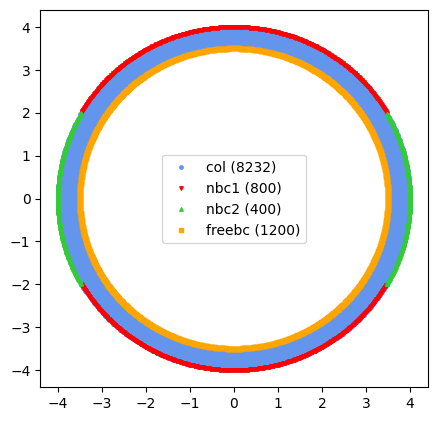

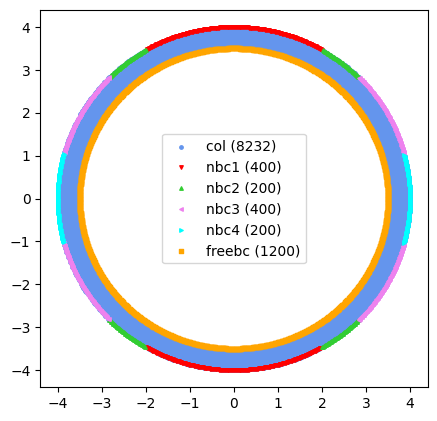

In [7]:
# surface points generation function
def PointsInSurface(radius=8.0/2.0, ox=0.0, oy=0.0, alpha1=0, alpha2=360, nrad=20, thick=1.0, nthick=1, ntype=1):
  linepoints = [(ox + np.cos((alpha2-alpha1)/360*2*np.pi/nrad*x + alpha1/360*2*np.pi)*radius, oy + np.sin((alpha2-alpha1)/360*2*np.pi/nrad*x + alpha1/360*2*np.pi)*radius) for x in range(0,nrad)]
  surfpoints = np.tile(linepoints, (nthick, 1))
  linenorm = [(np.cos((alpha2-alpha1)/360*2*np.pi/nrad*x + alpha1/360*2*np.pi), np.sin((alpha2-alpha1)/360*2*np.pi/nrad*x + alpha1/360*2*np.pi), 0.0) for x in range(0,nrad)]
  surfnorm = np.tile(linenorm, (nthick, 1))
  z = np.tile(np.linspace(0, thick, num=nthick), (nrad, 1)).T
  z = z.reshape(-1,1)
  pointtype = np.ones(nrad*nthick)*ntype
  pointtype = pointtype.reshape(-1,1)
  surf = np.hstack((surfpoints, z, surfnorm, pointtype))
  return surf

# generate the outer BC points
SurfP1_2f = np.vstack((PointsInSurface(alpha1=30, alpha2=150, nrad=400, ntype=1), PointsInSurface(alpha1=210, alpha2=330, nrad=400, ntype=1)))
SurfP2_2f = np.vstack((PointsInSurface(alpha1=0.0, alpha2=30, nrad=100, ntype=2), PointsInSurface(alpha1=150, alpha2=210, nrad=200, ntype=2), PointsInSurface(alpha1=330, alpha2=360, nrad=100, ntype=2)))
# generate the inner BC points
SurfFr_2f = np.vstack((PointsInSurface(radius=8.0/2.0-0.5, nrad=1200, ntype=3)))
# surface plot
plt.figure(figsize=(5,5), dpi=100)
plt.scatter(field_2f[:, 0], field_2f[:, 1], s=6, c='cornflowerblue', label='col (8232)')
plt.scatter(SurfP1_2f[:, 0], SurfP1_2f[:, 1], s=6, marker="v", c='red', label='nbc1 (800)')
plt.scatter(SurfP2_2f[:, 0], SurfP2_2f[:, 1], s=6, marker="^", c='limegreen', label='nbc2 (400)')
plt.scatter(SurfFr_2f[:, 0], SurfFr_2f[:, 1], s=6, marker="s", c='orange', label='freebc (1200)')
plt.legend()
plt.savefig("2f_grid.pdf", format='pdf', bbox_inches = "tight")
plt.show()




# generate the outer BC points
SurfP1_4f = np.vstack((PointsInSurface(alpha1=60, alpha2=120, nrad=200, ntype=1), PointsInSurface(alpha1=240, alpha2=300, nrad=200, ntype=1)))
SurfP2_4f = np.vstack((PointsInSurface(alpha1=45, alpha2=60, nrad=50, ntype=2), PointsInSurface(alpha1=120, alpha2=135, nrad=50, ntype=2), PointsInSurface(alpha1=225, alpha2=240, nrad=50, ntype=2), PointsInSurface(alpha1=300, alpha2=315, nrad=50, ntype=2)))
SurfP3_4f = np.vstack((PointsInSurface(alpha1=15, alpha2=45, nrad=100, ntype=3), PointsInSurface(alpha1=135, alpha2=165, nrad=100, ntype=3), PointsInSurface(alpha1=195, alpha2=225, nrad=100, ntype=3), PointsInSurface(alpha1=315, alpha2=345, nrad=100, ntype=3)))
SurfP4_4f = np.vstack((PointsInSurface(alpha1=0.0, alpha2=15, nrad=50, ntype=4), PointsInSurface(alpha1=165, alpha2=195, nrad=100, ntype=4), PointsInSurface(alpha1=345, alpha2=360, nrad=50, ntype=4)))
# generate the inner BC points
SurfFr_4f = np.vstack((PointsInSurface(radius=8.0/2.0-0.5, nrad=1200, ntype=5)))
plt.figure(figsize=(5,5), dpi=100)
plt.scatter(field_2f[:, 0], field_2f[:, 1], s=6, c='cornflowerblue', label='col (8232)')
plt.scatter(SurfP1_4f[:, 0], SurfP1_4f[:, 1], s=6, marker="v", c='red', label='nbc1 (400)')
plt.scatter(SurfP2_4f[:, 0], SurfP2_4f[:, 1], s=6, marker="^", c='limegreen', label='nbc2 (200)')
plt.scatter(SurfP3_4f[:, 0], SurfP3_4f[:, 1], s=6, marker="<", c='violet', label='nbc3 (400)')
plt.scatter(SurfP4_4f[:, 0], SurfP4_4f[:, 1], s=6, marker=">", c='aqua', label='nbc4 (200)')
plt.scatter(SurfFr_4f[:, 0], SurfFr_4f[:, 1], s=6, marker="s", c='orange', label='freebc (1200)')
plt.legend()
plt.savefig("4f_grid.pdf", format='pdf', bbox_inches = "tight")
plt.show()

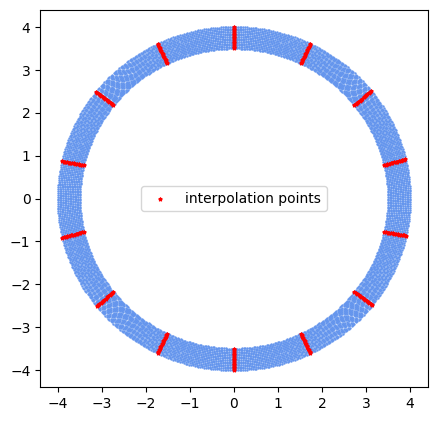

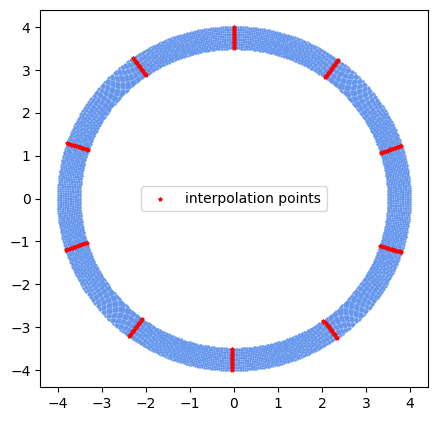

In [8]:
interpo_4fs = np.loadtxt("/content/drive/MyDrive/2Dring/results/meshgrid_measurement_14x14_4f_smallerror_xy.csv",dtype=float)
interpo_4fb = np.loadtxt("/content/drive/MyDrive/2Dring/results/meshgrid_measurement_14x10_4f_bigerror_xy.csv",dtype=float)

plt.figure(figsize=(5,5), dpi=100)
plt.setp(axs, xticks=[-4,-2,0,2,4], yticks=[-4,-2,0,2,4])
plt.scatter(field_2f[:, 0], field_2f[:, 1], s=0.5, c='cornflowerblue')
plt.scatter(interpo_4fs[:14,:].reshape(-1), interpo_4fs[14:,:].reshape(-1), s=6, marker="*", c='red', label='interpolation points')
plt.legend()
plt.savefig("interpo_4fs.pdf", format='pdf', bbox_inches = "tight")
plt.show()

plt.figure(figsize=(5,5), dpi=100)
plt.setp(axs, xticks=[-4,-2,0,2,4], yticks=[-4,-2,0,2,4])
plt.scatter(field_2f[:, 0], field_2f[:, 1], s=0.5, c='cornflowerblue')
plt.scatter(interpo_4fb[:14,:].reshape(-1), interpo_4fb[14:,:].reshape(-1), s=6, marker="*", c='red', label='interpolation points')
plt.legend()
plt.savefig("interpo_4fb.pdf", format='pdf', bbox_inches = "tight")
plt.show()

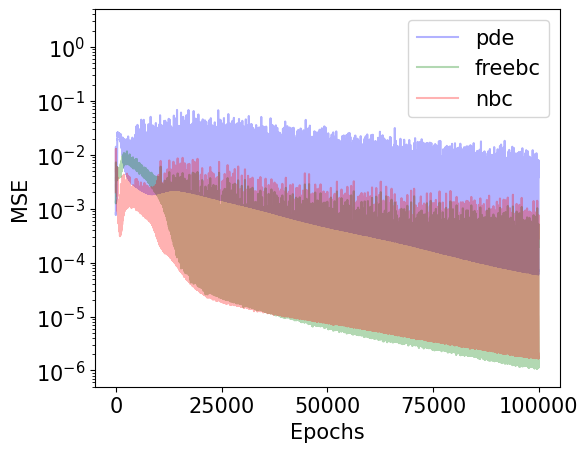

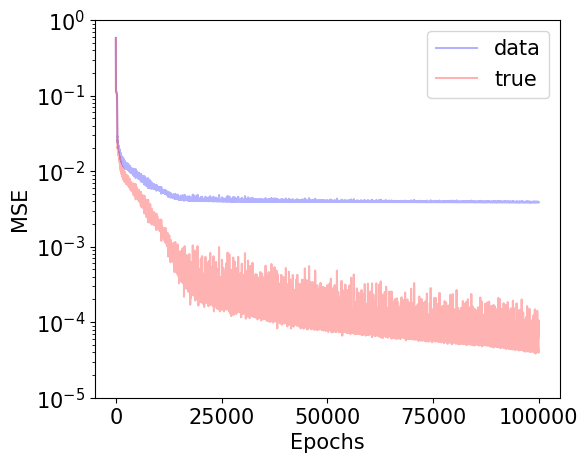

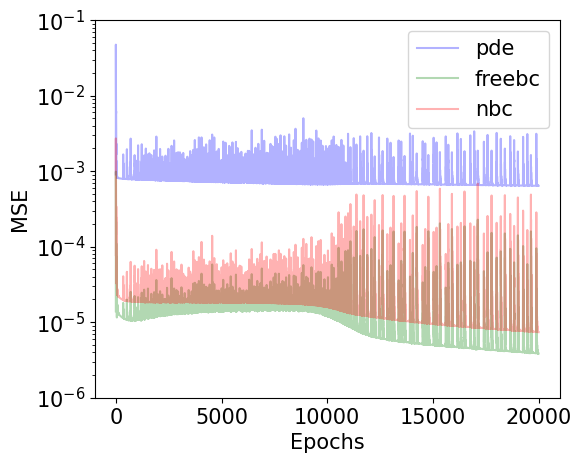

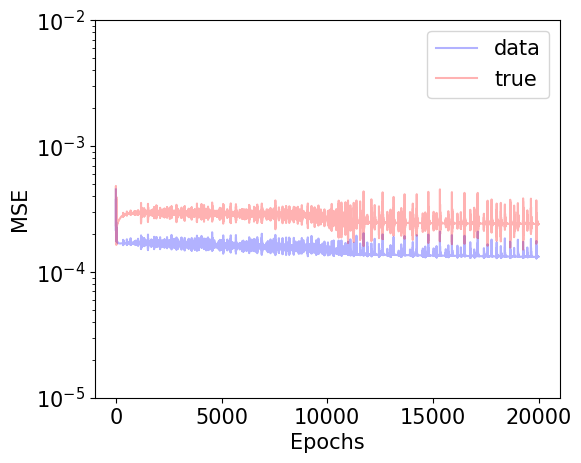

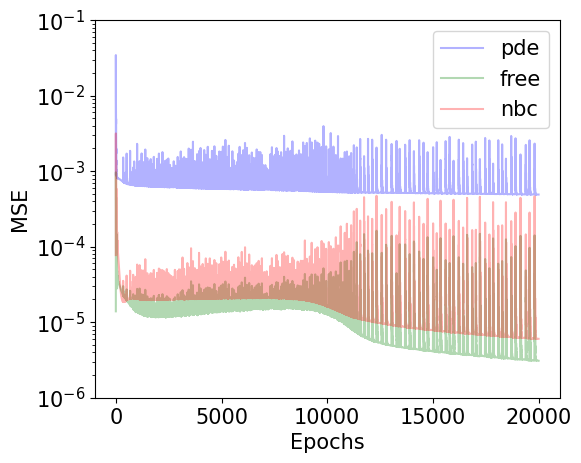

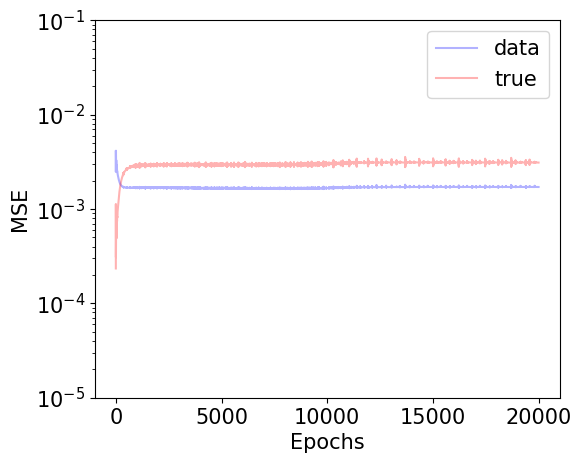

In [9]:
loss_2f = np.genfromtxt('/content/drive/MyDrive/2Dring/results/2Dring_2f_loss.txt', dtype = float)
loss_4f = np.genfromtxt('/content/drive/MyDrive/2Dring/results/2Dring_4f_loss_small.txt', dtype = float)
loss_4f_b = np.genfromtxt('/content/drive/MyDrive/2Dring/results/2Dring_4f_loss_big.txt', dtype = float)

plt.rcParams['font.size'] = 15

fig, ax = plt.subplots(figsize=(6, 5), dpi=100)
plt.plot(range(len(loss_2f[:,1])), loss_2f[:,1], 'b-', alpha=0.3, label='pde')
plt.plot(range(len(loss_2f[:,2])), loss_2f[:,2], 'g-', alpha=0.3, label='freebc')
plt.plot(range(len(loss_2f[:,3])), loss_2f[:,3]+loss_2f[:,4], 'r-', alpha=0.3, label='nbc')
ax.set_xticks([0,25000,50000,75000,100000])
ax.set_ylim(0.0000005,5)
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('MSE',fontsize=15)
plt.yscale('log')
plt.legend()
plt.savefig("loss_2f_a.pdf", format='pdf', bbox_inches = "tight")
plt.show()
fig, ax = plt.subplots(figsize=(6, 5), dpi=100)
plt.plot(range(len(loss_2f[:,5])), loss_2f[:,5], 'b-', alpha=0.3, label='data')
plt.plot(range(len(loss_2f[:,6])), loss_2f[:,6], 'r-', alpha=0.3, label='true')
ax.set_xticks([0,25000,50000,75000,100000])
ax.set_ylim(0.00001,1)
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('MSE',fontsize=15)
plt.yscale('log')
plt.legend()
plt.savefig("loss_2f_b.pdf", format='pdf', bbox_inches = "tight")
plt.show()

fig, ax = plt.subplots(figsize=(6, 5), dpi=100)
plt.plot(range(len(loss_4f[:,1])), loss_4f[:,1], 'b-', alpha=0.3, label='pde')
plt.plot(range(len(loss_4f[:,2])), loss_4f[:,2], 'g-', alpha=0.3, label='freebc')
plt.plot(range(len(loss_4f[:,3])), loss_4f[:,3]+loss_4f[:,4]+loss_4f[:,5]+loss_4f[:,6], 'r-', alpha=0.3, label='nbc')
ax.set_xticks([0,5000,10000,15000,20000])
ax.set_ylim(0.000001,0.1)
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('MSE',fontsize=15)
plt.yscale('log')
plt.legend()
plt.savefig("loss_4f_s1.pdf", format='pdf', bbox_inches = "tight")
plt.show()
fig, ax = plt.subplots(figsize=(6, 5), dpi=100)
plt.plot(range(len(loss_4f[:,7])), loss_4f[:,7], 'b-', alpha=0.3, label='data')
plt.plot(range(len(loss_4f[:,8])), loss_4f[:,8], 'r-', alpha=0.3, label='true')
ax.set_xticks([0,5000,10000,15000,20000])
ax.set_ylim(0.00001,0.01)
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('MSE',fontsize=15)
plt.yscale('log')
plt.legend()
plt.savefig("loss_4f_s2.pdf", format='pdf', bbox_inches = "tight")
plt.show()

fig, ax = plt.subplots(figsize=(6, 5), dpi=100)
plt.plot(range(len(loss_4f_b[:,1])), loss_4f_b[:,1], 'b-', alpha=0.3, label='pde')
plt.plot(range(len(loss_4f_b[:,2])), loss_4f_b[:,2], 'g-', alpha=0.3, label='free')
plt.plot(range(len(loss_4f_b[:,3])), loss_4f_b[:,3]+loss_4f_b[:,4]+loss_4f_b[:,5]+loss_4f_b[:,6], 'r-', alpha=0.3, label='nbc')
ax.set_xticks([0,5000,10000,15000,20000])
ax.set_ylim(0.000001,0.1)
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('MSE',fontsize=15)
plt.yscale('log')
plt.legend()
plt.savefig("loss_4f_b1.pdf", format='pdf', bbox_inches = "tight")
plt.show()
fig, ax = plt.subplots(figsize=(6, 5), dpi=100)
plt.plot(range(len(loss_4f_b[:,7])), loss_4f_b[:,7], 'b-', alpha=0.3, label='data')
plt.plot(range(len(loss_4f_b[:,8])), loss_4f_b[:,8], 'r-', alpha=0.3, label='true')
ax.set_xticks([0,5000,10000,15000,20000])
ax.set_ylim(0.00001,0.1)
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('MSE',fontsize=15)
plt.yscale('log')
plt.legend()
plt.savefig("loss_4f_b2.pdf", format='pdf', bbox_inches = "tight")
plt.show()

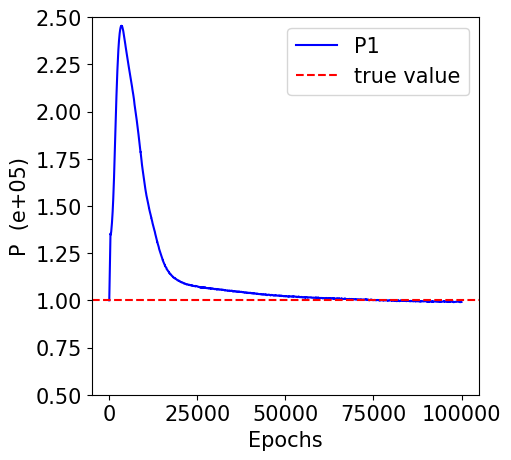

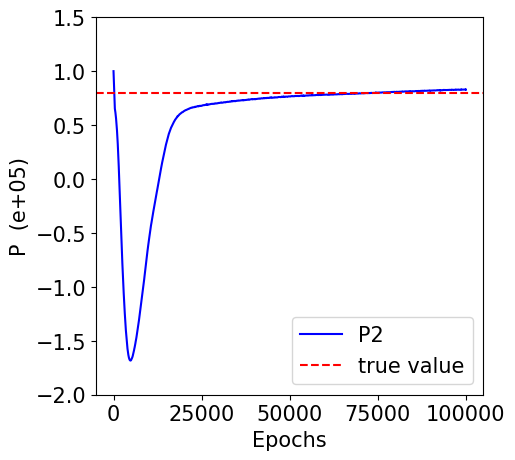

In [10]:
loss_2f = np.genfromtxt('/content/drive/MyDrive/2Dring/results/2Dring_2f_force.txt', dtype = float)
loss_4f = np.genfromtxt('/content/drive/MyDrive/2Dring/results/2Dring_4f_force_small.txt', dtype = float)
loss_4f_b = np.genfromtxt('/content/drive/MyDrive/2Dring/results/2Dring_4f_force_big.txt', dtype = float)

plt.rcParams['font.size'] = 15

fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
plt.plot(range(len(loss_2f[:,0])), loss_2f[:,0], 'b-', alpha=1.0, label='P1')
plt.axhline(y=1.0, color='r', linestyle='--', label='true value')
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('P  (e+05)',fontsize=15)
ax.set_xticks([0,25000,50000,75000,100000])
ax.set_ylim(0.5,2.5)
plt.legend()
plt.savefig("force_2f_P1.pdf", format='pdf', bbox_inches = "tight")
plt.show()
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
plt.plot(range(len(loss_2f[:,1])), loss_2f[:,1], 'b-', alpha=1.0, label='P2')
plt.axhline(y=0.8, color='r', linestyle='--', label='true value')
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('P  (e+05)',fontsize=15)
ax.set_xticks([0,25000,50000,75000,100000])
ax.set_ylim(-2.0,1.5)
plt.legend()
plt.savefig("force_2f_P2.pdf", format='pdf', bbox_inches = "tight")
plt.show()

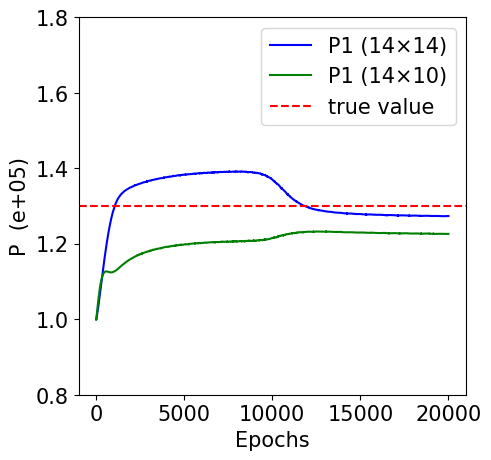

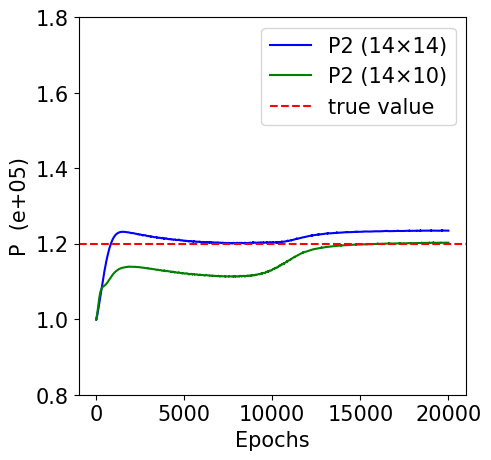

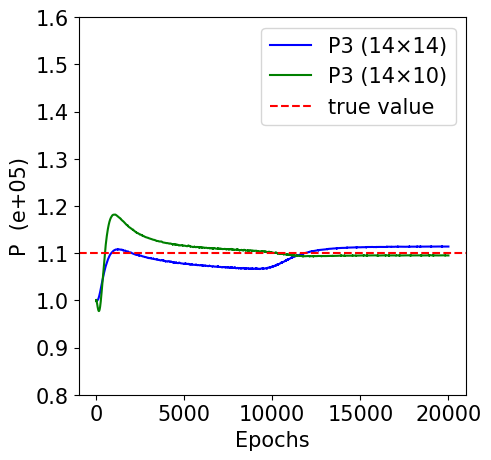

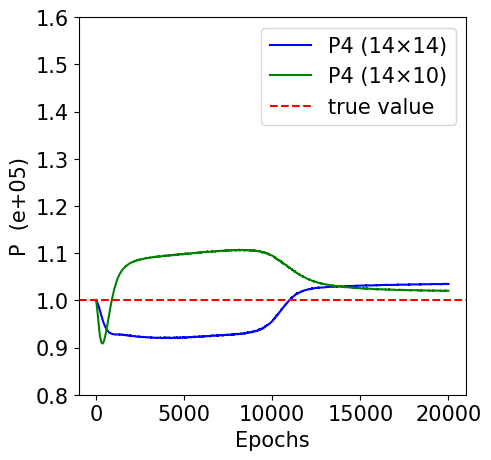

In [11]:
plt.rcParams['font.size'] = 15

fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
plt.plot(range(len(loss_4f[:,0])), loss_4f[:,0], 'b-', alpha=1.0, label='P1 (14×14)')
plt.plot(range(len(loss_4f_b[:,0])), loss_4f_b[:,0], 'g-', alpha=1.0, label='P1 (14×10)')
plt.axhline(y=1.3, color='r', linestyle='--', label='true value')
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('P  (e+05)',fontsize=15)
ax.set_xticks([0,5000,10000,15000,20000])
ax.set_ylim(0.8,1.8)
plt.legend()
plt.savefig("force_4f_P1.pdf", format='pdf', bbox_inches = "tight")
plt.show()
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
plt.plot(range(len(loss_4f[:,1])), loss_4f[:,1], 'b-', alpha=1.0, label='P2 (14×14)')
plt.plot(range(len(loss_4f_b[:,1])), loss_4f_b[:,1], 'g-', alpha=1.0, label='P2 (14×10)')
plt.axhline(y=1.2, color='r', linestyle='--', label='true value')
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('P  (e+05)',fontsize=15)
ax.set_xticks([0,5000,10000,15000,20000])
ax.set_ylim(0.8,1.8)
plt.legend()
plt.savefig("force_4f_P2.pdf", format='pdf', bbox_inches = "tight")
plt.show()
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
plt.plot(range(len(loss_4f[:,2])), loss_4f[:,2], 'b-', alpha=1.0, label='P3 (14×14)')
plt.plot(range(len(loss_4f_b[:,2])), loss_4f_b[:,2], 'g-', alpha=1.0, label='P3 (14×10)')
plt.axhline(y=1.1, color='r', linestyle='--', label='true value')
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('P  (e+05)',fontsize=15)
ax.set_xticks([0,5000,10000,15000,20000])
ax.set_ylim(0.8,1.6)
plt.legend()
plt.savefig("force_4f_P3.pdf", format='pdf', bbox_inches = "tight")
plt.show()
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
plt.plot(range(len(loss_4f[:,3])), loss_4f[:,3], 'b-', alpha=1.0, label='P4 (14×14)')
plt.plot(range(len(loss_4f_b[:,3])), loss_4f_b[:,3], 'g-', alpha=1.0, label='P4 (14×10)')
plt.axhline(y=1.0, color='r', linestyle='--', label='true value')
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('P  (e+05)',fontsize=15)
ax.set_xticks([0,5000,10000,15000,20000])
ax.set_ylim(0.8,1.6)
plt.legend()
plt.savefig("force_4f_P4.pdf", format='pdf', bbox_inches = "tight")
plt.show()